<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Treinamento_ShallowNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports e definições de funções

In [1]:
# !pip install tensorflow
# !pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import json
import sklearn
import numpy as np
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.models import Sequential

from mlxtend.plotting import plot_confusion_matrix
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from keras.callbacks import EarlyStopping

In [4]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            self.score = roc_auc_score(self.y_val, y_pred)
            self.false_positive_rate, self.true_positive_rate, _ = roc_curve(self.y_val, y_pred)          

# Carrega arquivo de saída (resultados)

In [5]:
# CONSTANTES DOS RESULTADOS
REDE = 'ShallowNet'

#BASE_NAME = 'BASE 0'
#BASE_NAME = 'BASE 1'
BASE_NAME = 'BASE 2'

# Caminho arquivo de saída
PATH_ARQ_SAIDA = "/content/drive/MyDrive/TCC/resultados/resultados.csv"

#  rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
resultados = pd.read_csv(PATH_ARQ_SAIDA, index_col=0)
resultados.head()

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix,epochs,rank
0,Bi-LSTM,BASE 0,Nadam,0.864151,0.359641,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 855, ""01"": 73, ""10"": 179, ""11"": 748}",4,2.402818
1,Bi-LSTM,BASE 0,Nadam,0.876550,0.302028,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 803, ""01"": 125, ""10"": 104, ""11"": 823}",4,2.902218
2,Bi-LSTM,BASE 0,Nadam,0.864151,0.318839,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 802, ""01"": 126, ""10"": 126, ""11"": 801}",4,2.710301
3,Bi-LSTM,BASE 0,RMSProp,0.852291,0.325597,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 800, ""01"": 128, ""10"": 146, ""11"": 781}",4,2.617622
4,Bi-LSTM,BASE 0,RMSProp,0.852291,0.327882,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 838, ""01"": 90, ""10"": 184, ""11"": 743}",4,2.599382


# Carrega base

In [6]:
if BASE_NAME == 'BASE 0':
  # PATH_BASE0_NAO_PROCESSADA  -Base0 Bruta Não processada
  PATH_BASE = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base0_classificada_balanceada.csv"

if BASE_NAME == 'BASE 1':
  # PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA - Base1 Com StopWords
  PATH_BASE = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"

if BASE_NAME == 'BASE 2':
  # PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA - Base2 Sem StopWords
  PATH_BASE = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"

In [7]:
# # Base0 Bruta Não processada
# PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv"
# #Base0 Bruta Não processada
# PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv"
# #MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')
# #MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')
# #MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

In [8]:
tweets = pd.read_csv(PATH_BASE, index_col=0)
tweets

,label,text
0,1,ambiguinho eu estou com nojo
1,1,menino do céu para que está feio
2,1,já pergunto a porra do trem já sabendo da vdd ...
3,1,sardella só faz merda
4,1,foda se na real vou tratar igual
...,...,...
4881,0,estou sem presidente por quatro anos nãomerepr...
4882,0,somos todos iguais braços dados ou não quem sa...
4883,0,que deus nos proteja e cuidem um do outro somo...
4884,0,quem será que não sabe votar


# Prepara os dados de train, test e validation da base


In [9]:
NUM_BASES = 4
# Carrega os paths das divisões das bases
LIST_PATH_TRAIN = []
LIST_PATH_TEST = []
LIST_PATH_VAL = []
for i in range(NUM_BASES):
  LIST_PATH_TRAIN.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/train'+str(i)+'.csv')
  LIST_PATH_TEST.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/test'+str(i)+'.csv')
  LIST_PATH_VAL.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/val'+str(i)+'.csv')

In [10]:
# 0 - Base0 bruta não processada
# 1 - Base1 Com StopWords
# 2 - Base2 Sem StopWords
# 3 - Base2 Nossa sem stopwords
base_index = int(BASE_NAME.split()[1])
base_train = pd.read_csv(LIST_PATH_TRAIN[base_index], index_col=0)
base_test = pd.read_csv(LIST_PATH_TEST[base_index], index_col=0)
base_val = pd.read_csv(LIST_PATH_VAL[base_index], index_col=0)

In [11]:
# Dados train
Y_TRAIN = base_train['label']
base_train.drop(['label'], axis='columns', inplace=True)
X_TRAIN = base_train.to_numpy()

# Dados test
Y_TEST = base_test['label']
base_test.drop(['label'], axis='columns', inplace=True)
X_TEST = base_test.to_numpy()

# Dados validation
Y_VAL = base_val['label']
base_val.drop(['label'], axis='columns', inplace=True)
X_VAL = base_val.to_numpy()

max_text_length = X_TRAIN.shape[1]

print(X_TRAIN.shape)
print(X_TEST.shape)
print(X_VAL.shape)

(2930, 24)
(978, 24)
(978, 24)


# Execução modelo

In [12]:
# parametros tunning:
BATCH_SIZE = [32, 64]
LEARN_RATE = [0.0001, 0.001]
OTMIZADORES = ['Nadam', 'RMSProp', 'SGD']
DROPOUT = 0

# parametros estaticos:
EPOCHS = 10
MAX_TEXT_SIZE = max_text_length 

In [13]:
def optimize (optimize, learning_rate):
  if optimize == 'Nadam':
    return Nadam(learning_rate=learning_rate, name="Nadam")
  
  if optimize == 'RMSProp':
    return RMSprop(learning_rate=learning_rate, name="RMSprop")
  
  if optimize == 'SGD':
    return SGD(learning_rate=learning_rate, name="SGD")

In [14]:
def create_shallowNet (max_text_size):

  modelo = keras.Sequential([                        
    keras.layers.Dense(max_text_size, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
    ])
  
  return modelo 

In [15]:
def train_model(batch_size, epochs, learning_rate, optimizer):
    opt = optimize(optimizer, learning_rate)
    
    model = create_shallowNet(MAX_TEXT_SIZE)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy'])        
    
    ra_val = RocAucEvaluation(validation_data=(X_VAL, Y_VAL), interval = 1)
    
    csv_logger = CSVLogger('log.csv', append=False, separator=';')

    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 0, patience = 1)                                                                                       
   
    history = model.fit(X_TRAIN, Y_TRAIN, batch_size=batch_size, epochs=epochs, validation_data=(X_VAL, Y_VAL), verbose=0, use_multiprocessing=True,  callbacks = [ra_val, csv_logger, early_stop])
    
    scores = model.evaluate(X_TEST, Y_TEST, verbose=0)
    
    return history, model, ra_val, scores, csv_logger


In [16]:
#history, model1, ra_val, scores, csv_logger = train_model(32, 1, 0.001, 'Nadam')

In [17]:
#my_log = pd.read_csv('log.csv',sep=';')
#my_log

In [18]:
# plot dos gráficos
count = 1
for BS in BATCH_SIZE:
  for LR in LEARN_RATE:
    for OT in OTMIZADORES:
      print("Iteração "+str(count))
      count+=1
      
      history, model1, ra_val, scores, csv_logger = train_model(BS, EPOCHS, LR, OT)

      #
      y_predito = model1.predict(X_TEST).round()
      y_gabarito = Y_TEST
      
      # Parâmetros
      # rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
      NOME_REDE = REDE
      NOME_BASE = BASE_NAME
      NOME_OTIMIZADOR = OT
      ACURACIA = scores[1]
      LOSS = scores[0] 
      LEARNING_RATE = LR
      DROPOUT_RATE = DROPOUT
      BATCH = BS
      ROC_CURVE = json.dumps({
          "false_positive_rate": list(ra_val.false_positive_rate),
          "true_positive_rate": list(ra_val.true_positive_rate),
          "score": ra_val.score})
      TRAIN_RESUME = json.dumps(pd.read_csv('log.csv',sep=';').to_dict()) 
      
      confusion = confusion_matrix(y_gabarito, y_predito)
      CONFUSION_MATRIX = json.dumps({
          "00": int(confusion[0][0]),
          "01": int(confusion[0][1]),
          "10": int(confusion[1][0]),
          "11": int(confusion[1][1])
      })

      EPOCHS = len(history.history['val_loss'])
      RANK = ACURACIA/LOSS

      # Salvando resultado do modelo
      registro_resultado = {resultados.columns[0]: NOME_REDE, 
                            resultados.columns[1]: NOME_BASE, 
                            resultados.columns[2]: NOME_OTIMIZADOR,
                            resultados.columns[3]: ACURACIA, 
                            resultados.columns[4]: LOSS,
                            resultados.columns[5]: LEARNING_RATE,
                            resultados.columns[6]: DROPOUT_RATE,
                            resultados.columns[7]: BATCH,
                            resultados.columns[8]: ROC_CURVE,
                            resultados.columns[9]: TRAIN_RESUME,
                            resultados.columns[10]: CONFUSION_MATRIX,
                            resultados.columns[11]: EPOCHS,
                            resultados.columns[12]: RANK,
                          }

      resultados = resultados.append(registro_resultado, ignore_index=True)

Iteração 1
Iteração 2
Iteração 3
Iteração 4
Iteração 5
Iteração 6
Iteração 7
Iteração 8
Iteração 9
Iteração 10
Iteração 11
Iteração 12


In [19]:
resultados.tail(12)

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix,epochs,rank
348,ShallowNet,BASE 2,Nadam,0.517382,85.381134,0.0001,0.0,32,"{""false_positive_rate"": [0.0, 0.29243353783231...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 312, ""01"": 177, ""10"": 295, ""11"": 194}",10,0.006060
349,ShallowNet,BASE 2,RMSProp,0.489775,101.377388,0.0001,0.0,32,"{""false_positive_rate"": [0.0, 0.25766871165644...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 346, ""01"": 143, ""10"": 356, ""11"": 133}",10,0.004831
350,ShallowNet,BASE 2,SGD,0.509202,17.531078,0.0001,0.0,32,"{""false_positive_rate"": [0.0, 0.41922290388548...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 177, ""01"": 312, ""10"": 168, ""11"": 321}",5,0.029046
351,ShallowNet,BASE 2,Nadam,0.530675,55.303123,0.0010,0.0,32,"{""false_positive_rate"": [0.0, 0.32924335378323...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 287, ""01"": 202, ""10"": 257, ""11"": 232}",5,0.009596
352,ShallowNet,BASE 2,RMSProp,0.553170,43.995167,0.0010,0.0,32,"{""false_positive_rate"": [0.0, 0.24539877300613...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 307, ""01"": 182, ""10"": 255, ""11"": 234}",5,0.012573
353,ShallowNet,BASE 2,SGD,0.501023,1.097059,0.0010,0.0,32,"{""false_positive_rate"": [0.0, 0.01022494887525...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 71, ""01"": 418, ""10"": 70, ""11"": 419}",5,0.456696
354,ShallowNet,BASE 2,Nadam,0.490798,182.208405,0.0001,0.0,64,"{""false_positive_rate"": [0.0, 0.24335378323108...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 358, ""01"": 131, ""10"": 367, ""11"": 122}",5,0.002694
355,ShallowNet,BASE 2,RMSProp,0.509202,175.864090,0.0001,0.0,64,"{""false_positive_rate"": [0.0, 0.30061349693251...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 323, ""01"": 166, ""10"": 314, ""11"": 175}",5,0.002895
356,ShallowNet,BASE 2,SGD,0.500000,82.666985,0.0001,0.0,64,"{""false_positive_rate"": [0.0, 0.0, 0.006134969...","{""epoch"": {""0"": 0, ""1"": 1}, ""accuracy"": {""0"": ...","{""00"": 486, ""01"": 3, ""10"": 486, ""11"": 3}",2,0.006048
357,ShallowNet,BASE 2,Nadam,0.496933,135.945312,0.0010,0.0,64,"{""false_positive_rate"": [0.0, 0.25766871165644...","{""epoch"": {""0"": 0, ""1"": 1}, ""accuracy"": {""0"": ...","{""00"": 329, ""01"": 160, ""10"": 332, ""11"": 157}",2,0.003655


In [20]:
# Caso queira deletar uma linha use o código abaixo
# Use a propriedade label para especificar o índice da linha
#resultados = resultados.drop(labels=1, axis=0)
#resultados = resultados.reset_index(drop=True)
#resultados

In [21]:
# Salva arquivo de saída
resultados.to_csv(PATH_ARQ_SAIDA)

In [22]:
#resultados.to_csv("/content/drive/MyDrive/TCC/resultados/resultados_para_leila.csv")

In [23]:
#tabela_para_leila = resultados.drop(['roc_curve', 'train_resume','confusion_matrix'], axis='columns', inplace=True)

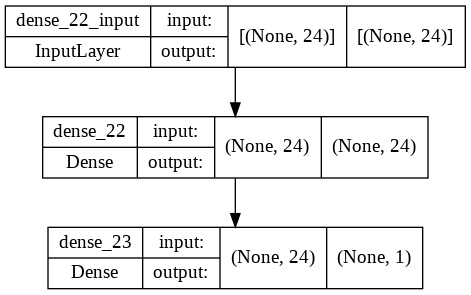

In [24]:
tf.keras.utils.plot_model(model1, to_file='/meuarquivo.png', show_shapes=True)

In [25]:
# Fazer a separação de Treinamento, Teste e validação 
  # Alterar todos os modelos para ler desse novo jeito
# Ver NaiveBayes, colocar na tabela
  # Falta salvar o treinamento no arquivo de resultados
# Ver ShallowNet, colocar na tabela
  # ler igual a tarefa1
# Rever LSTM
  # rever o foward e backward layer
# Prioridade é fechar o Resultado ( Tabelas )
  # Rodar tudo
# Ajustar Tabelas ( embelezar )
# Ajustar Graficos ( embelezar )
# Ver BiLstm / Otmizador 
# Gerar e Salvar os Graficos 
# Escrever Resultados
# Revisar Monografia
# Preparar apresentação

grafico Acuracy b1  
		b1 cnn melhor
		b1 lstm melhor
		.
		.

grafico Loss b1  
		b1 cnn melhor
		b1 lstm melhor
		.
		.

grafico Acuracy b2 
		b2 cnn melhor
		b2 lstm melhor
		.
		.

grafico Loss b2 
		b2 cnn melhor
		b2 lstm melhor
		.
		.

grafico Acuracy b0
		bo cnn melhor
		b0 lstm melhor

grafico Loss b0
		b0 cnn melhor
		b0 lstm melhor
		.
		.
